In [22]:
import random

import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import simplstyles
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, Ridge

from dataset import generate_dataset

In [23]:
set_backend('torch_cuda')
backend = get_backend()
simplstyles._
plt.style.use('nord-light-talk')
random.seed(42)

In [24]:
d_list = [100, 100, 100]
# scalars = [1 / 3, 1 / 2, 1 / 6]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 10000
n_samples = n_samples_train + n_samples_test
noise_target = 0.1
noise_feature = 0.0

In [25]:
alphas = np.logspace(-4, 4, 10)
cv = 2
score_func = himalaya.scoring.r2_score
use_ols = False

In [26]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target, noise_feature)

1.0000000000000007
1.0000000000000007


first of all lets verify that Ridge regression with $\alpha = 1$ indeed is equivalent to linear regression

In [27]:
# ridge = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))
# ridge.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
# ridge_coef = ridge.coef_  # (n_features, n_targets)

In [28]:
# linear = LinearRegression()
# linear.fit(backend.to_numpy(Xs[0][:n_samples_train]), backend.to_numpy(Y[:n_samples_train]))
# linear_coef = linear.coef_  # (n_targets, n_features)
# # swap rows and columns
# linear_coef = linear_coef.T

In [29]:
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).mean())
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).max())
# print((backend.to_numpy(ridge_coef) - np.array(linear_coef)).min())
# sns.displot(backend.to_numpy(linear_coef) - backend.to_numpy(ridge_coef))


compute on full feature sets for comparison

0.5775918
0.57704


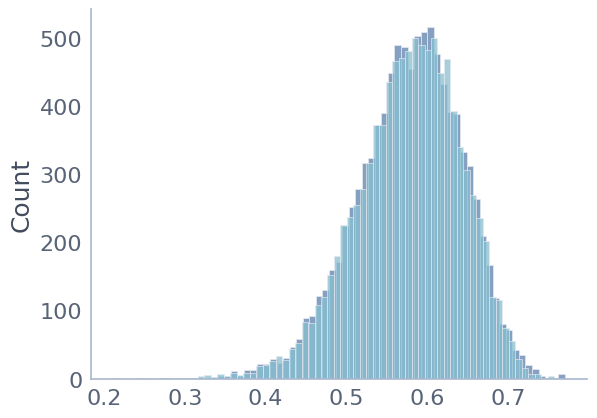

In [30]:
full_scores = []
for i in range(len(Xs)):
    full_model = RidgeCV(alphas=alphas, cv=cv,
                         solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    full_model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    full_score = full_model.score(Xs[i][n_samples_train:], Y[n_samples_train:])
    full_score = backend.to_numpy(full_score)
    print(full_score.mean())
    sns.histplot(full_score)
    full_scores.append(full_score)

# Feature to feature regression

### OLS

In [31]:
ols_model = Ridge(alpha=1, solver_params=dict(warn=False, n_targets_batch=1000))

In [32]:
ols_feature_scores = []
Xs_predict = []
for i in range(len(Xs)):
    i_from = (i + 1) % len(Xs)
    i_to = i
    ols_model.fit(Xs[i_from][:n_samples_train], Xs[i_to][:n_samples_train])

    X_predict = ols_model.predict(Xs[i_from])
    X_predict = backend.asarray(X_predict)
    Xs_predict.append(X_predict)
    feature_score = ols_model.score(Xs[i_from][n_samples_train:], Xs[i_to][n_samples_train:])
    feature_score = backend.to_numpy(feature_score)
    ols_feature_scores.append(feature_score)

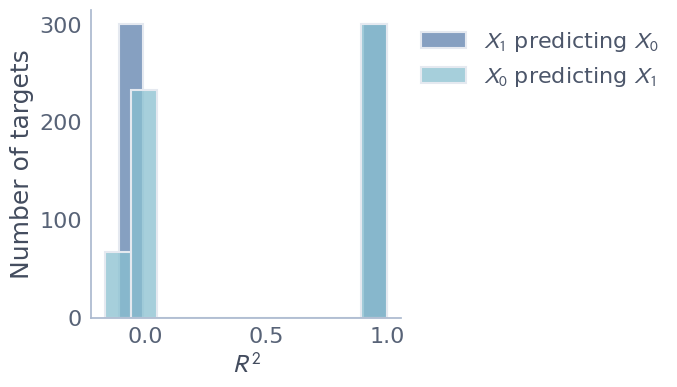

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i, score in enumerate(ols_feature_scores):
    sns.histplot(score, label=rf'$X_{(i + 1) % 2}$ predicting $X_{i}$')

plt.xlabel(r"$R^2$")
plt.ylabel("Number of targets")
sns.despine()
# plot legend to the top right
plt.legend(bbox_to_anchor=(1, 1))

Compute residuals

In [34]:
Xs_ols_residual = []
for i in range(len(Xs)):
    X_residual = Xs[i] - Xs_predict[i]
    X_residual = backend.asarray(X_residual)
    Xs_ols_residual.append(X_residual)

### Ridge

In [35]:
ridge_model = RidgeCV(alphas=alphas, cv=cv,
                      solver_params=(dict(warn=False, score_func=score_func, n_targets_batch=1000)))

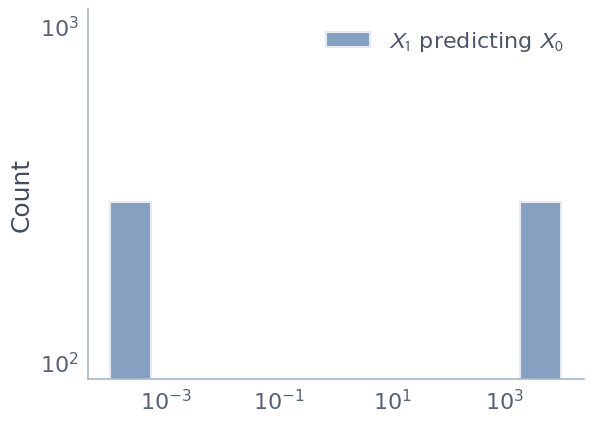

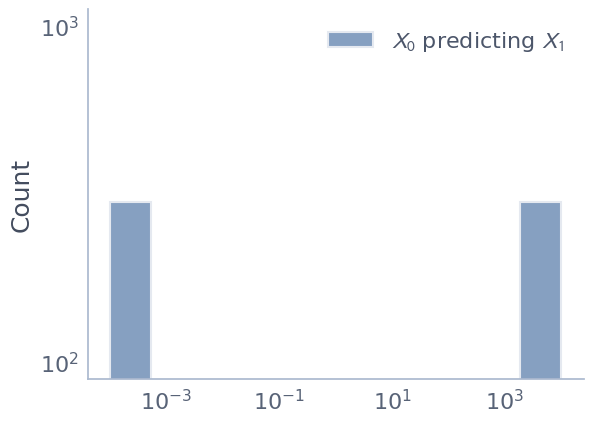

In [36]:
ridge_feature_scores = []
Xs_ridge_predict = []
for i in range(len(Xs)):
    i_from = (i + 1) % len(Xs)
    i_to = i
    ridge_model.fit(Xs[i_from][:n_samples_train], Xs[i_to][:n_samples_train])

    X_predict = ridge_model.predict(Xs[i_from])
    X_predict = backend.asarray(X_predict)
    Xs_ridge_predict.append(X_predict)
    feature_score = ridge_model.score(Xs[i_from][n_samples_train:], Xs[i_to][n_samples_train:])
    feature_score = backend.to_numpy(feature_score)
    ridge_feature_scores.append(feature_score)
    sns.histplot(x=backend.to_numpy(ridge_model.best_alphas_), log_scale=True,
                 label=rf'$X_{(i + 1) % 2}$ predicting $X_{i}$')
    plt.yscale('log')
    plt.legend()
    plt.show()

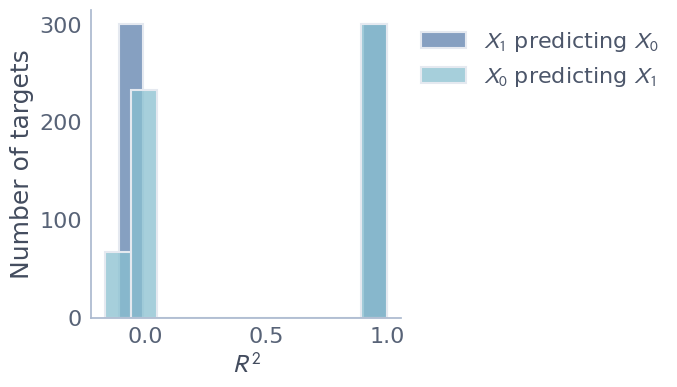

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for i, score in enumerate(ols_feature_scores):
    sns.histplot(score, label=rf'$X_{(i + 1) % 2}$ predicting $X_{i}$')

plt.xlabel(r"$R^2$")
plt.ylabel("Number of targets")
sns.despine()
# plot legend to the top right
plt.legend(bbox_to_anchor=(1, 1))

In [38]:
Xs_ridge_residual = []
for i in range(len(Xs)):
    X_residual = Xs[i] - Xs_ridge_predict[i]
    X_residual = backend.asarray(X_residual)
    Xs_ridge_residual.append(X_residual)

# Compare Variance removed in B/C

In [39]:
Xs_ridge_residual[0].device

device(type='cuda', index=0)

In [40]:
residual_variances_ols = np.array([np.var(backend.to_numpy(Xs_ols_residual[i])[:, 300:]) for i in range(len(Xs))])
residual_variances_ridge = np.array([np.var(backend.to_numpy(Xs_ridge_residual[i])[:, 300:]) for i in range(len(Xs))])

/tmp/ipykernel_40608/3383702660.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(residual_variances, ax=ax, palette=["C1", "C3"])
/tmp/ipykernel_40608/3383702660.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(residual_variances, ax=ax, palette=["C1", "C3"])


([<matplotlib.axis.XTick at 0x7fc819348b90>,
 [Text(0, 0, "$\\mathbf{B}'$"), Text(1, 0, "$\\mathbf{C}'$")])

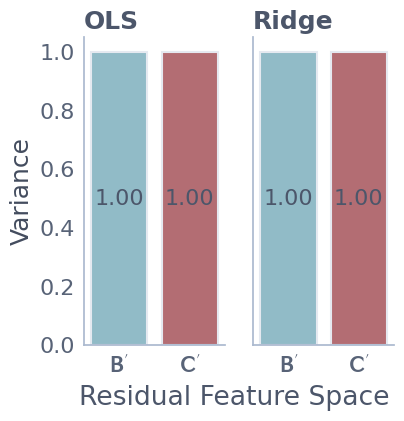

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(4, 4), sharex=True, sharey=True)

for ax, residual_variances, title in zip(axs, [residual_variances_ols, residual_variances_ridge], ["OLS", "Ridge"]):
    sns.barplot(residual_variances, ax=ax, palette=["C1", "C3"])
    ax.set_title(title)

    for idx, column in enumerate(residual_variances):
        xmin = idx / len(residual_variances)  # Calculate xmin for each bar
        xmax = (idx + 1) / len(residual_variances)  # Calculate xmax for each bar

        # Use the mean of the column for positioning text

        ax.text(idx, column / 2, f"{column:.2f}", ha='center', va='center')
axs[0].set_ylabel("Variance")
fig.supxlabel("Residual Feature Space", va="top")

plt.xticks(range(2), [r"$\mathbf{B}'$", r"$\mathbf{C}'$"])

In [42]:
np.var(Xs_ols_residual[0]), np.var(Xs_ridge_residual[0])

TypeError: var() received an invalid combination of arguments - got (ddof=int, dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (tuple of ints dim, bool unbiased = True, bool keepdim = False)
 * (tuple of ints dim = None, *, Number correction = None, bool keepdim = False)
      didn't match because some of the keywords were incorrect: ddof, dtype, out, axis
 * (bool unbiased = True)
 * (tuple of names dim, bool unbiased = True, bool keepdim = False)
 * (tuple of names dim, *, Number correction = None, bool keepdim = False)
      didn't match because some of the keywords were incorrect: ddof, dtype, out, axis


In [ ]:
np.var(Xs_ols_residual[0][:, 300:]), np.var(Xs_ridge_residual[0][:, 300:])

In [ ]:
np.var(Xs_ols_residual[1][:, 300:]), np.var(Xs_ridge_residual[1][:, 300:])

# Compare feature to feature regression weights

In [ ]:
# ols_weights = ols_model.coef_
# ridge_weights = backend.to_numpy(ridge_model.coef_)
#
# fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
#
# for ax_, weights, title in zip(ax, [ols_weights, ridge_weights], ['OLS', 'Ridge']):
#     sns.histplot(weights, ax=ax_, bins=50)
#     ax_.set_title(title)
#     ax_.set_xlabel("Weight")
#     ax_.set_ylabel("Number of weights")
#     ax_.set_yscale('log')
#     ax_.set_xscale('symlog')

# Train residual model

In [ ]:
residual_ols_scores = []
residual_ridge_scores = []

for i in range(len(Xs)):
    residual_model = RidgeCV(alphas=alphas, cv=cv,
                             solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    residual_model.fit(Xs_ols_residual[i][:n_samples_train], Y[:n_samples_train])
    residual_score = residual_model.score(Xs_ols_residual[i][n_samples_train:], Y[n_samples_train:])
    residual_score = backend.to_numpy(residual_score)
    residual_ols_scores.append(residual_score)

    residual_model = RidgeCV(alphas=alphas, cv=cv,
                             solver_params=dict(warn=False, score_func=score_func, n_targets_batch=1000))
    residual_model.fit(Xs_ridge_residual[i][:n_samples_train], Y[:n_samples_train])
    residual_score = residual_model.score(Xs_ridge_residual[i][n_samples_train:], Y[n_samples_train:])
    residual_score = backend.to_numpy(residual_score)
    residual_ridge_scores.append(residual_score)

# Plot Scores

In [ ]:
import pandas as pd
import os

path = os.path.join('results', f'residual_method_{scalars}.csv')
if not os.path.exists(path):
    scores = pd.DataFrame()
    scores[r"$X_1$"] = full_scores[0]
    scores[r"$X_2$"] = full_scores[1]
    scores[r"$X_1'_{ridge}$"] = residual_ridge_scores[0]
    scores[r"$X_2'_{ridge}$"] = residual_ridge_scores[1]
    scores[r"$X_1'_{OLS}$"] = residual_ols_scores[0]
    scores[r"$X_2'_{OLS}$"] = residual_ols_scores[1]
    scores.to_csv(path)
else:
    scores = pd.read_csv(path, index_col=0)

scores.head()

In [ ]:
ols_scores = scores[[r"$X_1'_{OLS}$", r"$X_2'_{OLS}$"]]
ridge_scores = scores[[r"$X_1'_{ridge}$", r"$X_2'_{ridge}$"]]

fig, ax = plt.subplots(1, 2, figsize=(4, 4), sharey=True)

for ax_, scores_ in zip(ax, [ols_scores, ridge_scores]):
    scores_.columns = [r"$\mathbf{B}$", r"$\mathbf{C}$"]

    sns.barplot(data=scores_, palette=["C1", "C3"], ax=ax_, errorbar='sd')
    ax_.set_ylim(0, 1.01)

    # Add lines indicating the maximum possible height for each bar
    theoretical_scores = np.array([scalars[1], scalars[2]]) * (1 - noise_target)

    for idx, column in enumerate(scores_.columns):  # iterate over rows in the DataFrame
        # Ensure index compatibility
        if column not in scores_:
            print(f"Column '{column}' is not present in DataFrame. Available columns are: {list(ols_scores.columns)}")
            continue

        xmin = idx / len(scores_.columns)  # Calculate xmin for each bar
        xmax = (idx + 1) / len(scores_.columns)  # Calculate xmax for each bar
        ax_.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, xmin=xmin, xmax=xmax,
                    label='Expected Value' if idx == 0 else "")

        # Use the mean of the column for positioning text
        mean_column_value = scores_[column].mean()
        ax_.text(idx, mean_column_value / 2, f"{mean_column_value:.2f}", ha='center', va='center')

ax[0].set_xlabel(r"OLS")
ax[0].set_ylabel(r"$R^2$ (avg. and sd)")
ax[1].set_xlabel(r"Ridge")
plt.legend( loc='upper left', frameon=True)
# plt.legend()

In [ ]:
scores.columns = [
    r"A,B",
    r"A,C",
    r"$B_{ridge}$",
    r"$C_{ridge}$",
    r"$B_{OLS}$",
    r"$C_{OLS}$",
]

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=scores,
    ax=ax,
    palette=["C0", "C0", "C1", "C1", "C1", "C1"],
    errorbar="sd"
)

sns.despine()

# Add lines indicating the maximum possible height for each bar
theoretical_scores = [
    (scalars[0] + scalars[1]) * (1 - noise_target),
    (scalars[0] + scalars[2]) * (1 - noise_target),
    scalars[1] * (1 - noise_target),
    scalars[2] * (1 - noise_target),
    scalars[1] * (1 - noise_target),
    scalars[2] * (1 - noise_target),
]

for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    # Ensure index compatibility
    if column not in scores:
        print(f"Column '{column}' is not present in DataFrame. Available columns are: {list(scores.columns)}")
        continue

    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, xmin=xmin, xmax=xmax,
                label='EV' if idx == 0 else "")

    # Use the mean of the column for positioning text
    mean_column_value = scores[column].mean()
    plt.text(idx, mean_column_value / 2, f"{mean_column_value:.2f}", ha='center', va='center', fontsize=12)

# make xtickmarks diagonal
plt.xticks(range(len(scores.columns)), scores.columns, va='top')

plt.ylim(0, 1)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (avg. and sd)")
plt.xlabel("Feature Space(s)")